## Predicting DC PCSB's Annual Performance Management Framework (PMF) Tiers

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Read & Clean Data

In [47]:
pmf_data = pd.read_csv('../pmf-predictions/data/pmf_data_final.csv')

In [48]:
## set index
pmf_data.set_index(['school_code','school_name'],inplace = True);
## preview data
pmf_data.head()

,,school_year,pmf_score,pmf_tier,framework,ward,years_in_operation,money_spent_on_personnel_%,asian_%,black_%,hispanic_%,...,growth_assessment,ela_growth_%,math_growth_%,achievement_assessment,ela_3+_%,ela_4+_%,math_3+_%,math_4+_%,isa_%,reenrollment_%
school_code,school_name,,,,,,,,,,,,,,,,,,,,,
217,Achievement Preparatory Academy PCS - Wahler Place Elementary School,2018-2019,60.10%,2.0,PK-8,8,7,51.360076,0.0,97.1,1.9,...,NWEA MAP,63.5,65.0,PARCC,32.3,14.5,48.4,19.4,88.8,64.4
1100,Achievement Preparatory Academy PCS - Wahler Place Middle School,2018-2019,35.30%,2.0,PK-8,8,12,51.360076,0.0,97.6,0.7,...,PARCC,41.1,42.5,PARCC,39.9,19.5,35.0,12.5,91.3,80.2
3068,BASIS DC PCS,2018-2019,84.30%,1.0,PK-8,2,8,57.726752,7.2,33.8,8.6,...,PARCC,62.5,52.5,PARCC,94.6,79.5,88.7,67.6,96.6,90.0
142,Bridges PCS,2018-2019,50.00%,2.0,PK-8,5,15,68.766596,1.2,51.9,31.1,...,PARCC,46.1,42.9,PARCC,43.2,19.4,51.4,19.6,93.6,78.4
184,Capital City PCS - Lower School,2018-2019,56.70%,2.0,PK-8,4,20,70.450341,1.9,32.2,51.1,...,PARCC,51.8,43.0,PARCC,47.5,15.2,52.5,28.3,93.6,89.9


In [49]:
##Remove percent sign from PMF Score Column
pmf_data['pmf_score'] = pmf_data['pmf_score'].str.replace('%','')
## Convert PMF Score to a numeric feature
pmf_data['pmf_score'] = pd.to_numeric(pmf_data['pmf_score'])
pmf_data['pmf_score'].dtypes

dtype('float64')

In [50]:
## fill reenrollment rates & student growth with average
pmf_data['reenrollment_%'].fillna(pmf_data['reenrollment_%'].mean(),inplace=True)
pmf_data['ela_growth_%'].fillna(pmf_data['ela_growth_%'].mean(),inplace=True)
pmf_data['math_growth_%'].fillna(pmf_data['math_growth_%'].mean(),inplace=True)
## remove schools with no tier
pmf_data.dropna(subset= ['pmf_tier'], inplace=True)
## Check for zero nulls 
pmf_data.isnull().sum().sum()

0

In [8]:
## Map assessments to numeric values
pmf_data['growth_assessment'] = pmf_data.growth_assessment.map({'PARCC':0, 'NWEA MAP':1})

### Feature Selection
#### Initial Determination of Features Not to Include
Before using a correlation matrix, I was able to make a few determinations about features I would <i>not</i> include.
- <b>PMF Score</b> corresponds to a Tier naturally. A score above 65.0% is Tier 1, between 35.0% and 65.9% is Tier 2, and a Tier 3 is anything 34.9% and below. 
- <b> Race or Ethnicity Values </b> are not used because the DC Charte Sector is not particularly diverse. Special population values such as students with disabilities, english learners, and at-risk students are more useful.

#### Feature Selection Using a Correlation Matrix and Heatmap
The correlation heatmap revealed a few details about what features I should include and/or exclude. The PMF Tier is highly correlated with all of the academic measures such as ELA Growth, Math Achievement, ELA Achievement, etc. Growth is a strong predictor of success on the framework. Achievement on the state assessment (represented here by students scoring level 3+ or 4+) is also a strong predictor. Since level 3+ and level 4+ is just a repackaging of the data, these are substantially similar measures. I chose one for each subject to reduce multicolinearity. 

<b>Initial Features selected:</b>
- Ward
- Money Spend on Personnel (Salaries and Benefits)
- SPED (%)
- ELL (%)
- At-Risk (%)
- ELA Growth (%)
- Math Growth (%)
- ELA %4+
- Math %3+
- Reenrollment (%)

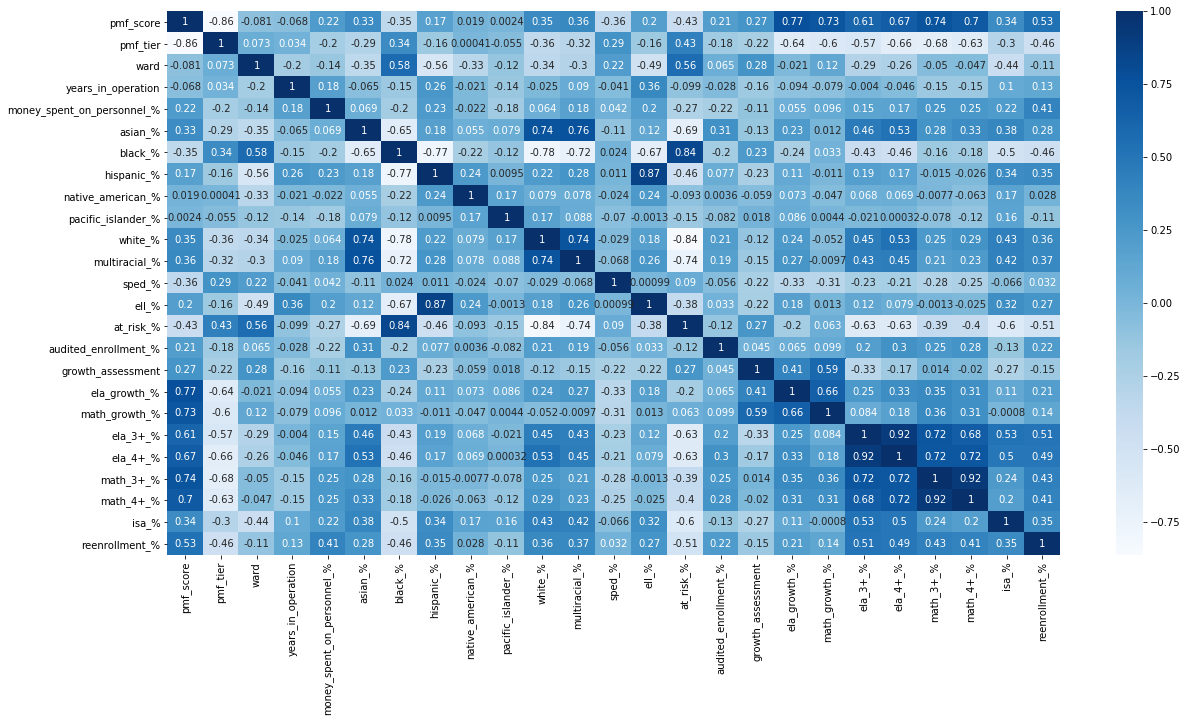

In [9]:
## plot correlation of variables/ features
plt.figure(figsize=(20,10))
sns.heatmap(pmf_data.corr(),annot = True, cmap = 'Blues');

### Create Feature Dataframe & Target Dataframe

In [10]:
## create feature columns object
feature_cols = ['ward','money_spent_on_personnel_%','sped_%','ell_%','at_risk_%','ela_growth_%','math_growth_%',
               'ela_4+_%','math_3+_%','reenrollment_%']

## Select features and target variable
X = pmf_data[feature_cols]
y = pmf_data.pmf_tier

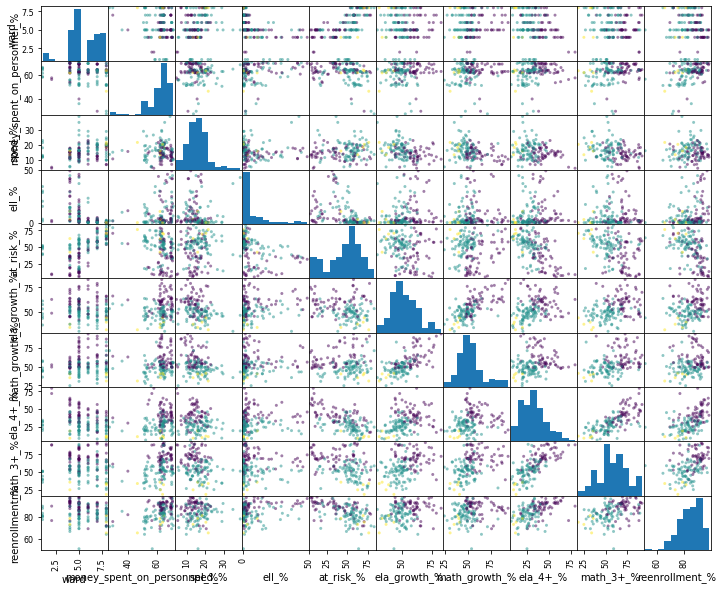

In [11]:
# Scatter matrix of all features, colored by species.
pd.plotting.scatter_matrix(X, c=pmf_data.pmf_tier, figsize=(12, 10));

## Build Model 1 
<b>Uses Data that will not be calcualted in SY 2019-20 due to covid-19 impacts</b>

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

In [13]:
# Split data into a training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

In [14]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [15]:
y_pred_class = pd.Series(knn.predict(X_test))

#### Examine Class Fequency and Compute Null Accuracy 

In [16]:
# class frequency of test data
most_freq_class = y_test.value_counts().index[0]
print(f'The most frequent class is ' + 'Tier ' + str(most_freq_class))

The most frequent class is Tier 2.0


In [17]:
# null accuracy 
print(f'The null accuracy is {round(y_test.value_counts()[most_freq_class] / len(y_test),2)}')

The null accuracy is 0.51


### Tune Model 1

#### Find best value of K between 1 and 100

In [18]:
k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100
for k in k_range:

    # Instantiate the model with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy)
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [19]:
# Create a DataFrame of K
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.tail(6)

,training error,testing error
K,,
6,0.102740,0.081081
5,0.075342,0.135135
4,0.047945,0.108108
3,0.068493,0.135135
2,0.089041,0.162162
1,0.034247,0.135135


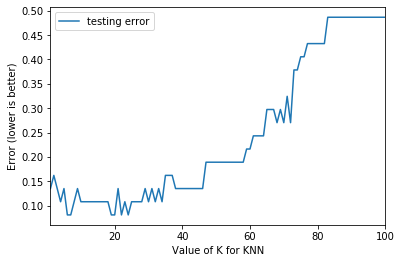

In [20]:
# Plot the relationship between K and the testing error
df.plot(y='testing error');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

In [21]:
# Find optimal value of K
min(list(zip(testing_error, k_range)))

(0.08108108108108103, 6)

### Rebuild Model 1 with Optimal Value of K

In [22]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [23]:
y_pred_class = pd.Series(knn.predict(X_test))

### Evaluate the Performance of Model 1
While accuracy is not only metrics we should rely on for classification problems, it is nonetheless as useful tool for evaluating the performance of the model quickly and in a layperson could understand. 

If we predicted the most frequent class in the data (Tier 2), we would be right 51.0% of the time. Using the KNN model build, the accuracy improves to <b>91.9%</b>. This is accuracy is as close to 100 as I could get when developing the model. 

In [24]:
## calculate accuracy of model
testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
round(testing_accuracy * 100,1)

91.9

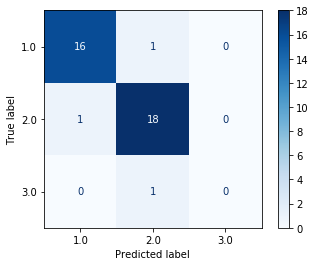

In [25]:
## plot confusion matrix
disp = plot_confusion_matrix(knn,X_test,y_test,cmap = 'Blues',values_format='.3g')

#### Use `StandardScaler` in attempt to improve model
`StandardScaler` was not particularly useful in this case and the code is commented out. 

In [26]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X_ = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [27]:
# Calculate testing error.
#knn = KNeighborsClassifier(n_neighbors=6)
#knn.fit(X_train, y_train)

#y_pred_class = knn.predict(X_test)
#testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
#testing_error = 1 - testing_accuracy

#print(testing_error)

## Build Model 2 
<b>Uses data that will be available for SY 2019-20 despite covid-19 impact</b>

In [28]:
## create feature columns object with data that we will have from the current school_year
feature_cols = ['ward','money_spent_on_personnel_%','sped_%','ell_%','at_risk_%','isa_%','black_%',
               'white_%','hispanic_%']

## Select features and target variable
X = pmf_data[feature_cols]
y = pmf_data.pmf_tier

In [29]:
# Split data into a training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

In [30]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [31]:
y_pred_class = pd.Series(knn.predict(X_test))

### Tune Model 2

In [32]:
k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100
for k in k_range:

    # Instantiate the model with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy)
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [33]:
# Create a DataFrame of K
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.tail(6)

,training error,testing error
K,,
6,0.273973,0.351351
5,0.260274,0.351351
4,0.246575,0.351351
3,0.184932,0.351351
2,0.171233,0.297297
1,0.061644,0.243243


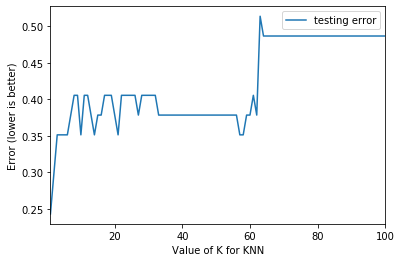

In [34]:
# Plot the relationship between K and the testing error
df.plot(y='testing error');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

In [35]:
# Find optimal value of K
min(list(zip(testing_error, k_range)))

(0.2432432432432432, 1)

### Rebuild Model 2 with Optimal Value of K

In [36]:
##ignore this part for Model 2 as the optimal value of k =1 was already used

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred_class = pd.Series(knn.predict(X_test))

### Evaluate the Performance of Model 2
Model 2 does not perform as well as Model 1 as expected. The academic variables included in Model 1 are not included in Model 2. The null accuracy was 51%, and the accuracy of the model is 73.0%. However, Model 2 may prove to be more useful than Model 1 for the purposes of this project.

Due to the impacts of covid-19 on the education sector in DC, state assessments have been cancelled. We will not have state assessment data in SY 2019-20 to be able to make predictions on new data, but we will have in-seat attendance rates frozen from when school closed.

In [37]:
## calculate accuracy of model
testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
round(testing_accuracy * 100,1)

75.7

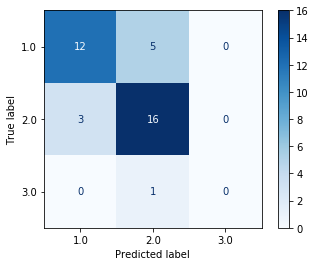

In [38]:
## create confusion matrix
disp = plot_confusion_matrix(knn,X_test,y_test,cmap = 'Blues',values_format='.3g')

### Practical Use Case Example: Predictions for Out-of-Sample Data

In [45]:
import numpy as np

# NOTE of features used: 
# feature_cols = ['ward','money_spent_on_personnel_%','sped_%','ell_%','at_risk_%','isa_%','black_%',
         #      'white_%','hispanic_%']
    
# Make a prediction for an out-of-sample observation using SY 2019-20 data
# school_name = Bridges PCS
bridges_prediction = knn.predict(np.array(['5','68.7','35.4','47.1','39.9','92.2','53.2','6.6','34.8']).reshape(1, -1));

/Users/tseay/Library/Python/3.7/lib/python/site-packages/sklearn/neighbors/_classification.py:171: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  X = check_array(X, accept_sparse='csr')
/Users/tseay/Library/Python/3.7/lib/python/site-packages/sklearn/neighbors/_base.py:604: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  X = check_array(X, accept_sparse='csr')


In [46]:
bridges_prediction

array([2.])